# Modeling Stock Returns

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.formula.api as smf
from pandas.plotting import scatter_matrix

In [59]:
import warnings
warnings.filterwarnings('ignore')

In [60]:
psei = pd.read_csv('Data2.csv', index_col=1, parse_dates=True)
psei = psei.iloc[:, 1:-1]
psei.head()

,Open,High,Low,Close
Date/Time,,,,
1958-01-31,3.06,3.06,3.06,3.06
1958-02-28,2.92,2.92,2.92,2.92
1958-03-31,3.15,3.15,3.15,3.15
1958-04-30,3.45,3.45,3.45,3.45
1958-05-31,3.56,3.56,3.56,3.56


In [61]:
psei['LogReturn'] = np.log(psei['Close']).shift(-1) - np.log(psei['Close'])
psei.head()

,Open,High,Low,Close,LogReturn
Date/Time,,,,,
1958-01-31,3.06,3.06,3.06,3.06,-0.046831
1958-02-28,2.92,2.92,2.92,2.92,0.075819
1958-03-31,3.15,3.15,3.15,3.15,0.090972
1958-04-30,3.45,3.45,3.45,3.45,0.031386
1958-05-31,3.56,3.56,3.56,3.56,0.211844


In [62]:
psei_2014 = psei['2014-01-01':]
psei_2014.head()

,Open,High,Low,Close,LogReturn
Date/Time,,,,,
2014-01-02,5923.7202,5984.2598,5923.7202,5984.2598,-0.006089
2014-01-03,5971.3599,5971.3599,5903.7700,5947.9302,0.006348
2014-01-06,5950.3901,5992.9800,5932.5098,5985.8101,-0.006431
2014-01-07,5986.1802,5991.9302,5946.7202,5947.4399,0.006543
2014-01-08,5948.2998,5995.0698,5942.6802,5986.4800,-0.008214


In [63]:
mu = psei_2014['LogReturn'].mean()
sigma = psei_2014['LogReturn'].std(ddof=1)

density = pd.DataFrame()
density['x'] = np.arange(psei_2014['LogReturn'].min() - 0.01,
                        psei_2014['LogReturn'].max() + 0.01,
                        0.001)
density['pdf'] = norm.pdf(density['x'], mu, sigma)

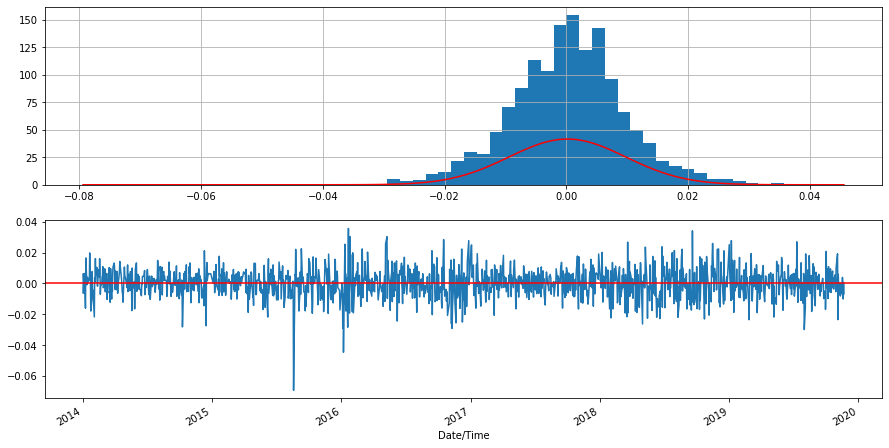

In [64]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8))

psei_2014['LogReturn'].hist(bins=50, ax = ax[0])
ax[0].plot(density['x'], density['pdf'], color='red');

psei_2014['LogReturn'].plot(ax=ax[1])
ax[1].axhline(0, color='red');

# Compute probs

In [65]:
print(f'Probability of a 5% drop: {norm.cdf(-0.05, mu, sigma)}')
print(f'Probability of a 10% drop: {norm.cdf(-0.1, mu, sigma)}')

Probability of a 5% drop: 8.709918109547475e-08
Probability of a 10% drop: 8.956099236108118e-26


In [66]:
year_mu = mu * 220
year_sigma = sigma * np.sqrt(220)
print(f'Probability of a 20% drop in a year: {norm.cdf(-0.2, year_mu, year_sigma)}')
print(f'Probability of a 40% drop in a year: {norm.cdf(-0.4, year_mu, year_sigma)}')

Probability of a 20% drop in a year: 0.045955339771050506
Probability of a 40% drop in a year: 0.0010029687799430087


# VAR

In [67]:
print(f'Single day 5% VAR: {norm.ppf(0.05, mu, sigma)}')
print(f'95% quantile: {norm.ppf(0.95, mu, sigma)}')

Single day 5% VAR: -0.015615488387171013
95% quantile: 0.01597998768175726


In [68]:
print(f'25% quantile: {norm.ppf(0.25, mu, sigma)}')
print(f'75% quantile: {norm.ppf(0.75, mu, sigma)}')

25% quantile: -0.006295781106286636
75% quantile: 0.00666028040087289


# Hypothesis Testing

In [69]:
n = psei_2014.shape[0]
std_error = sigma / np.sqrt(n)

z_left = norm.ppf(0.05)
z_right = norm.ppf(0.95)

left_interval = mu + z_left * std_error
right_interval = mu + z_right * std_error

print(f'90% confidence interval of avg returns: {left_interval, right_interval}')

90% confidence interval of avg returns: (-0.00023478194603003509, 0.0005992812406162882)


# Test Statistic

In [70]:
zhat = (mu - 0) / (std_error)
zhat

0.718828017253907

In [71]:
alpha = 0.05

zleft = norm.ppf(alpha/2)
zright = -zleft

print(f'Two tailed: {zleft, zright}')
print(f'At {alpha} signifance level, reject null: {zhat > zright}')

Two tailed: (-1.9599639845400545, 1.9599639845400545)
At 0.05 signifance level, reject null: False


In [72]:
zright = norm.ppf(1-alpha)

print(f'One tail: {zright}')
print(f'At {alpha} signifance level, reject null: {zhat > zright}')

One tail: 1.6448536269514722
At 0.05 signifance level, reject null: False


# P Value

In [73]:
p = 1 - norm.cdf(zhat)

print(f'p value: {p}')
print(f'At {alpha} significance level, reject null: {p < alpha}')

p value: 0.23612344633002535
At 0.05 significance level, reject null: False


# Linear Regression

In [76]:
psei_2014['Y'] = psei_2014['Close'].shift(-1) - psei_2014['Close']
psei_2014.head()

,Open,High,Low,Close,LogReturn,Y
Date/Time,,,,,,
2014-01-02,5923.7202,5984.2598,5923.7202,5984.2598,-0.006089,-36.3296
2014-01-03,5971.3599,5971.3599,5903.7700,5947.9302,0.006348,37.8799
2014-01-06,5950.3901,5992.9800,5932.5098,5985.8101,-0.006431,-38.3702
2014-01-07,5986.1802,5991.9302,5946.7202,5947.4399,0.006543,39.0401
2014-01-08,5948.2998,5995.0698,5942.6802,5986.4800,-0.008214,-48.9702


In [77]:
for i in range(9):
    psei_2014['X' + str(i)] = np.log(psei_2014['Close'].shift(i)) - np.log(psei_2014['Close'].shift(i+1))
psei_2014.head()

,Open,High,Low,Close,LogReturn,Y,X0,X1,X2,X3,X4,X5,X6,X7,X8
Date/Time,,,,,,,,,,,,,,,
2014-01-02,5923.7202,5984.2598,5923.7202,5984.2598,-0.006089,-36.3296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,5971.3599,5971.3599,5903.7700,5947.9302,0.006348,37.8799,-0.006089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,5950.3901,5992.9800,5932.5098,5985.8101,-0.006431,-38.3702,0.006348,-0.006089,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,5986.1802,5991.9302,5946.7202,5947.4399,0.006543,39.0401,-0.006431,0.006348,-0.006089,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,5948.2998,5995.0698,5942.6802,5986.4800,-0.008214,-48.9702,0.006543,-0.006431,0.006348,-0.006089,NaN,NaN,NaN,NaN,NaN


In [78]:
psei_2014.dropna(inplace=True)
psei_2014.head(10)

,Open,High,Low,Close,LogReturn,Y,X0,X1,X2,X3,X4,X5,X6,X7,X8
Date/Time,,,,,,,,,,,,,,,
2014-01-15,5938.3301,5969.1602,5938.3301,5958.1201,0.004040,24.1201,0.003794,-0.000861,0.016598,-0.016066,-0.008214,0.006543,-0.006431,0.006348,-0.006089
2014-01-16,5977.9600,5999.5801,5972.3901,5982.2402,0.000810,4.8496,0.004040,0.003794,-0.000861,0.016598,-0.016066,-0.008214,0.006543,-0.006431,0.006348
2014-01-17,5993.0898,6008.2202,5960.9800,5987.0898,0.003087,18.5103,0.000810,0.004040,0.003794,-0.000861,0.016598,-0.016066,-0.008214,0.006543,-0.006431
2014-01-20,5988.3901,6019.7500,5988.3901,6005.6001,0.002269,13.6401,0.003087,0.000810,0.004040,0.003794,-0.000861,0.016598,-0.016066,-0.008214,0.006543
2014-01-21,6006.5898,6030.9702,5983.8901,6019.2402,0.019841,120.6197,0.002269,0.003087,0.000810,0.004040,0.003794,-0.000861,0.016598,-0.016066,-0.008214
2014-01-22,6020.3999,6147.1802,6020.3999,6139.8599,0.004905,30.1899,0.019841,0.002269,0.003087,0.000810,0.004040,0.003794,-0.000861,0.016598,-0.016066
2014-01-23,6145.1602,6180.7300,6139.7402,6170.0498,0.003470,21.4502,0.004905,0.019841,0.002269,0.003087,0.000810,0.004040,0.003794,-0.000861,0.016598
2014-01-24,6166.5801,6195.6401,6095.5898,6191.5000,-0.017908,-109.8901,0.003470,0.004905,0.019841,0.002269,0.003087,0.000810,0.004040,0.003794,-0.000861
2014-01-27,6185.5801,6185.5801,6035.9800,6081.6099,-0.009716,-58.7998,-0.017908,0.003470,0.004905,0.019841,0.002269,0.003087,0.000810,0.004040,0.003794


In [80]:
train_size = 0.8
train_idx = int(len(psei_2014) * train_size)

train = psei_2014.iloc[:train_idx, 5:]
test = psei_2014.iloc[train_idx:, 4:]

print(train.shape, test.shape)

(1140, 10) (285, 11)


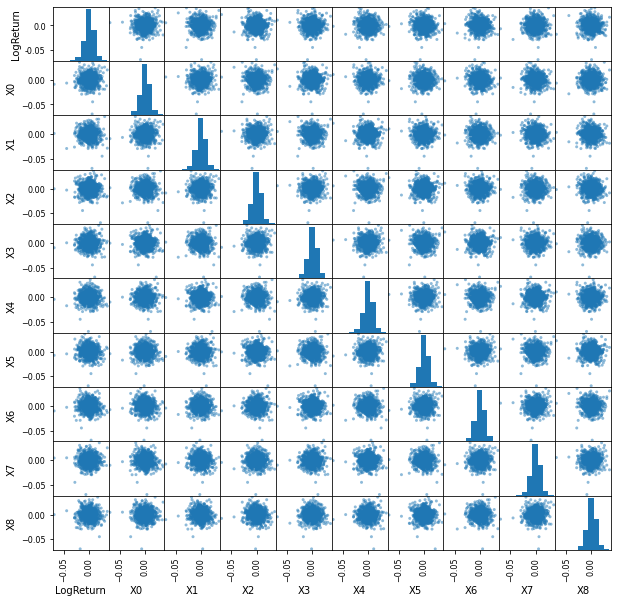

In [52]:
sm = scatter_matrix(train, figsize=(10, 10))

In [82]:
train.corr()['Y']

Y     1.000000
X0    0.026754
X1   -0.038117
X2   -0.011470
X3   -0.002843
X4   -0.017969
X5   -0.066600
X6   -0.033246
X7    0.009890
X8   -0.036113
Name: Y, dtype: float64

In [83]:
formula = 'Y~X0+X1+X2+X3+X4+X5+X6+X7+X8'
lm = smf.ols(formula=formula, data=train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.228
Date:                Tue, 21 Sep 2021   Prob (F-statistic):              0.274
Time:                        21:59:25   Log-Likelihood:                -6459.0
No. Observations:                1140   AIC:                         1.294e+04
Df Residuals:                    1130   BIC:                         1.299e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5500      2.083      0.744      0.457      -2.537       5.637
X0           181.6093    218.171      0.832      0.405    -246.457     609.675
X1          -296.8817    219.468     -1.353      0.176    -727.493     133.730
X2           -98.0034    219.476     -0.447      0.655    -528.629     332.622
X3           -43.6094    218.727     -0.199      0.842    -472.767     385.548
X4          -135.2016    219.013     -0.617      0.537    -564.920     294.517
X5          -482.1181    218.970     -2.202      0.028    -911.751     -52.485
X6          -243.6020    219.605     -1.109      0.268    -674.482     187.278
X7            53.5106    219.619      0.244      0.808    -377.397     484.418
X8          -300.4778    219.620     -1.368      0.172    -731.387     130.431
==============================================================================
Omnibus:                      111.024   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              369.557
Skew:                          -0.450   Prob(JB):                     5.65e-81
Kurtosis:                       5.640   Cond. No.                         113.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
train['y_hat'] = lm.predict(train)
test['y_hat'] = lm.predict(test)

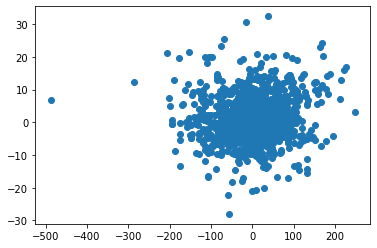

In [86]:
plt.scatter(train['Y'], train['y_hat'])